# Capstone 1: Machine Learning Algorithms - Varied Sampling Methods

In [70]:
from imblearn.ensemble import BalancedRandomForestClassifier

ImportError: cannot import name 'BalancedRandomForestClassifier'

<a id='TOC'></a>
**Table of Contents**
1. Preliminaries
    1. [Import EMS Incident Data](#Sec01A)
    2. [Preprocess Dataset](#Sec01B)
    3. [Segment & Encode Feature Variables](#Sec01C)
    4. [Inspect Target Variable](#Sec01D)
2. Over-Sampling Methods
    1. [Random Over-Sampling](#Sec02A)
    2. [SMOTE](#Sec02B)
    3. [ADASYN](#Sec02C)
3. Under-Sampling Methods
    1. [Random Under-Sampling](#Sec03A)
    2. [Near Miss](#Sec03B)
    3. [Tomek's Links](#Sec03C)
4. Combination Methods
    1. [Balanced Random Forest](#Sec04A)
5. Evaluation of Classifiers
    1. [Logistic Regression](#Sec05A)
    2. [](#Sec05B)

The goal of this project is to develop machine learning models that predict whether or not the outcome of an EMS incident will result in a fatality. This is a supervised, binary classification problem. Analyses will be performed on a collection of nearly 8 million records of documented incidents, which span the six year period from January 2013 through December 2018, and appropriate predictive models will be developed to achieve the primary objective. This dataset is robust and contains several feature variables, of mixed data types, that describe both various attributes of each incident as well as the responsive action taken by the FDNY. All of the aforementioned factors affect an individual’s survivability once a response is initiated.

The results from the [previous notebook](https://github.com/jdwill917/SB-DSCT-Repo/blob/master/Capstones/Capstone%201/code/CP1-04a_MLA.ipynb) illustrated that the underlying dataset is highly imbalanced on the target variable: `fatality`. This notebook will examine several models generated by combining different sampling algorithms (over-sampling, under-sampling, and ensemble) and classifiers (parametric and non-parametric). The primary metric that will be used to evaluate each model is *sensitivity* (the fraction of correctly identified positives within the target variable), but other metrics tailored to imbalanced dataset will also be taken into consideration.

**Expand upon the results of the baseline model from CP1-04a and discuss techniques that will be used to deal with the imbalanced dataset**

## 1. PRELIMINARIES

<a id='Sec01A'></a>
#### 1A: Import EMS incident data

In [ ]:
# Import packages and modules
import pandas as pd
import numpy as np
import category_encoders as ce
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline
#sb.set(style='whitegrid',color_codes=True)

# Model evaluation tools and metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, classification_report,
                             precision_score, recall_score, f1_score,
                             confusion_matrix, plot_confusion_matrix,
                             roc_curve, precision_recall_curve,)
from imblearn.metrics import classification_report_imbalanced

# Prospective classifiers
from imblearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Assign file path
file_path = '../data/clean_EMS_data.csv'

# Read CSV data into a Pandas DataFrame
datetime_cols = ['incident_datetime',
                 'first_assignment_datetime',
                 'first_activation_datetime',
                 'first_on_scene_datetime',
                 'first_to_hosp_datetime',
                 'first_hosp_arrival_datetime',
                 'incident_close_datetime']

df = pd.read_csv(file_path,compression='gzip',
                 parse_dates=datetime_cols,
                 index_col=['incident_datetime'])

In [3]:
df.info(verbose=True,memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7988028 entries, 2013-01-01 00:00:04 to 2018-12-19 00:19:39
Data columns (total 29 columns):
year                           int64
month                          int64
day                            int64
hour                           int64
weekday                        int64
borough                        object
zipcode                        float64
latitude                       float64
longitude                      float64
aland_sqmi                     float64
awater_sqmi                    float64
initial_call_type              object
initial_severity_level         int64
final_call_type                object
final_severity_level           int64
held_indicator                 object
first_assignment_datetime      datetime64[ns]
incident_dispatch_area         object
dispatch_time                  int64
first_activation_datetime      datetime64[ns]
first_on_scene_datetime        datetime64[ns]
travel_time                    floa

[TOC](#TOC)

<a id="Sec01B"></a>
#### 1B: Preprocess Dataset

In [4]:
# Change dtypes
df['borough'] = df.borough.astype('category')
df['zipcode'] = df.zipcode.astype('category')

In [5]:
# Remove immaterial columns
list_of_cols = ['latitude','longitude',
                'aland_sqmi','awater_sqmi','held_indicator',
                'initial_call_type','initial_severity_level',
                'first_assignment_datetime','incident_dispatch_area',
                'dispatch_time','travel_time',
                'first_activation_datetime','first_on_scene_datetime',
                'first_to_hosp_datetime','first_hosp_arrival_datetime',
                'incident_close_datetime','incident_disposition_code']
df.drop(list_of_cols,axis=1,inplace=True)

In [6]:
df.info(verbose=True,memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7988028 entries, 2013-01-01 00:00:04 to 2018-12-19 00:19:39
Data columns (total 12 columns):
year                    int64
month                   int64
day                     int64
hour                    int64
weekday                 int64
borough                 category
zipcode                 category
final_call_type         object
final_severity_level    int64
response_time           float64
life_threatening        bool
fatality                bool
dtypes: bool(2), category(2), float64(1), int64(6), object(1)
memory usage: 997.4 MB


In [7]:
df.head()

,year,month,day,hour,weekday,borough,zipcode,final_call_type,final_severity_level,response_time,life_threatening,fatality
incident_datetime,,,,,,,,,,,,
2013-01-01 00:00:04,2013,1,1,0,2,BRONX,10472.0,RESPIR,4,797.0,False,False
2013-01-01 00:05:52,2013,1,1,0,2,BRONX,10472.0,EDP,7,534.0,False,False
2013-01-01 00:20:37,2013,1,1,0,2,BRONX,10472.0,SICK,6,697.0,False,False
2013-01-01 01:53:11,2013,1,1,1,2,BRONX,10472.0,INJURY,4,223.0,False,False
2013-01-01 01:54:28,2013,1,1,1,2,BRONX,10472.0,SICK,4,298.0,False,False


[TOC](#TOC)

<a id="Sec01C"></a>
#### 1C: Segment & Encode Feature Variables

In [8]:
# Nominal feature variables
var_names_nom = ['borough','zipcode','final_call_type']
vars_nom = df[var_names_nom]

# Binary encode dataframe
enc_binary = ce.BinaryEncoder(cols=var_names_nom)
df_bin = enc_binary.fit_transform(df)

# Inspect encoded dataframe
print(df_bin.shape)
df_bin.head()

(7988028, 31)


,year,month,day,hour,weekday,borough_0,borough_1,borough_2,borough_3,zipcode_0,...,final_call_type_3,final_call_type_4,final_call_type_5,final_call_type_6,final_call_type_7,final_call_type_8,final_severity_level,response_time,life_threatening,fatality
incident_datetime,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:04,2013,1,1,0,2,0,0,0,1,0,...,0,0,0,0,0,1,4,797.0,False,False
2013-01-01 00:05:52,2013,1,1,0,2,0,0,0,1,0,...,0,0,0,0,1,0,7,534.0,False,False
2013-01-01 00:20:37,2013,1,1,0,2,0,0,0,1,0,...,0,0,0,0,1,1,6,697.0,False,False
2013-01-01 01:53:11,2013,1,1,1,2,0,0,0,1,0,...,0,0,0,1,0,0,4,223.0,False,False
2013-01-01 01:54:28,2013,1,1,1,2,0,0,0,1,0,...,0,0,0,0,1,1,4,298.0,False,False


In [9]:
# Target variable
y_bin = df_bin['fatality'].values
print('y\nType:  {0}\nShape: {1}\n'
      .format(type(y_bin),y_bin.shape))

# All feature variables
X_bin = df_bin.iloc[:,:-1].values
print('X (Binary-Encoded)\nType:  {0}\nShape: {1}'
      .format(type(X_bin),X_bin.shape))

y
Type:  <class 'numpy.ndarray'>
Shape: (7988028,)

X (Binary-Encoded)
Type:  <class 'numpy.ndarray'>
Shape: (7988028, 30)


Applying binary encoding increases the number of feature variables in the clean dataset from 11 to 30. [TOC](#TOC)

<a id="Sec01D"></a>
#### 1D: Inspect Target Variable

In [10]:
# Subsets for two classes of target
fatalities = df_bin[df_bin.fatality == True] # positives
survivals = df_bin[df_bin.fatality == False] # negatives

# Calculate frequency and proportion of classes
n_pos = len(fatalities.fatality)
n_neg = len(df_bin['fatality']) - n_pos
pct_pos = (n_pos/len(df_bin['fatality'])) * 100
pct_neg = 100 - pct_pos

# Output results
print("Fatalities: {0:7} ({1:5.4}%)".format(n_pos,pct_pos))
print("Survivals:  {0:7} ({1:5.4}%)".format(n_neg,pct_neg))

Fatalities:  338684 ( 4.24%)
Survivals:  7649344 (95.76%)


The target variable is segmented into two *imbalanced* classes: __fatalities__ (`fatality == True`) and __survivals__ (`fatality == False`). Based on the frequency values provided above, __fatalities__ represent the *minority* class (4.24%) whereas __survivals__ represent the *majority* class (95.76%). Various sampling techniques will be utilized in the sections to follow in order to develop effective models for analyses. [TOC](#TOC)

***

## 2. PRELIMINARY EVALUATION OF CLASSIFIERS

In [11]:
RANDOM_STATE = 917
TEST_SIZE = 0.25

In [ ]:
# Define function to evaluate classifier
def eval_clf(clf, df_scores, clf_name=None):
    from sklearn.pipeline import Pipeline
    if clf_name is None:
        if isinstance(clf, Pipeline):
            clf_name = clf[-1].__class__.__name__
        else:
            clf_name = clf.__class__.__name__
    acc = clf.fit(X_train, y_train).score(X_test, y_test)
    y_pred = clf.predict(X_test)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    clf_score = pd.DataFrame(
        {clf_name: [acc, bal_acc]},
        index=['Accuracy', 'Balanced accuracy']
    )
    df_scores = pd.concat([df_scores, clf_score], axis=1).round(decimals=4)
    return df_scores

df_base_scores = pd.DataFrame() # Instantiate dataframe to contains scores for baseline classifiers

In [13]:
# Split the binary encoded data into a training and test set
X_train, X_test, y_train, y_test = train_test_split(X_bin, y_bin, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [20]:
X_train.shape

(5991021, 30)

In [22]:
X_bin.shape

(7988028, 30)

In [23]:
y_bin.shape

(7988028,)

Under-Sampling

In [21]:
from imblearn.under_sampling import NearMiss

In [24]:
nm = NearMiss(random_state=42)
X_res, y_res =nm.fit_sample(X_bin,y_bin)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [25]:
print("X_res: {}".format(X_res.shape))
print("y_res:  {}".format(y_res.shape))

X_res: (677368, 30)
y_res:  (677368,)


Classifier: Logistic Regression

In [29]:
# Split the binary encoded data into a training and test set
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=TEST_SIZE, random_state=716)

In [28]:
# Instantiate a baseline logistic regression model
clf_lr = LogisticRegression(max_iter=10000)

In [30]:
# Fit the model to the undersampled, binary encoded dataset
clf_lr.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [32]:
y_pred_training = clf_lr.predict(X_train)
y_pred_test = clf_lr.predict(X_test)

print('Classification Report:')
print(classification_report(y_train, y_pred_training))
print('\n')
print('Classification Report:')
print(classification_report(y_test, y_pred_test))

Classification Report:
              precision    recall  f1-score   support

       False       0.66      0.73      0.69    254057
        True       0.70      0.63      0.66    253969

    accuracy                           0.68    508026
   macro avg       0.68      0.68      0.68    508026
weighted avg       0.68      0.68      0.68    508026



Classification Report:
              precision    recall  f1-score   support

       False       0.66      0.72      0.69     84627
        True       0.69      0.63      0.66     84715

    accuracy                           0.68    169342
   macro avg       0.68      0.68      0.68    169342
weighted avg       0.68      0.68      0.68    169342



In [ ]:
print('Classification Report:')
print(classification_report_imbalanced(y_train, y_pred_training))
print('\n')
print('Classification Report:')
print(classification_report_imbalanced(y_test, y_pred_test))

In [84]:
y_train.shape

(508026,)

In [85]:
y_pred_training.shape

(11473300,)

Over-Sampling

In [26]:
from imblearn.combine import SMOTETomek

In [27]:
smk = SMOTETomek(random_state=42)
X_smk,y_smk = smk.fit_sample(X_bin,y_bin)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/anaconda3/lib

In [37]:
# Split the binary encoded data into a training and test set
X_train_smk, X_test_smk, y_train_smk, y_test_smk = train_test_split(X_smk, y_smk, test_size=TEST_SIZE, random_state=1025)

In [38]:
# Fit the model to the oversampled, binary encoded dataset
clf_lr.fit(X_train_smk,y_train_smk)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [39]:
y_pred_training = clf_lr.predict(X_train_smk)
y_pred_test = clf_lr.predict(X_test_smk)

print('Classification Report - Training Set:')
print(classification_report(y_train_smk, y_pred_training))
print('\n')
print('Classification Report - Test Set:')
print(classification_report(y_test_smk, y_pred_test))

Classification Report:
              precision    recall  f1-score   support

       False       0.68      0.67      0.68   5737312
        True       0.68      0.68      0.68   5735988

    accuracy                           0.68  11473300
   macro avg       0.68      0.68      0.68  11473300
weighted avg       0.68      0.68      0.68  11473300



Classification Report:
              precision    recall  f1-score   support

       False       0.68      0.67      0.68   1911555
        True       0.68      0.68      0.68   1912879

    accuracy                           0.68   3824434
   macro avg       0.68      0.68      0.68   3824434
weighted avg       0.68      0.68      0.68   3824434



In [24]:
# Define function to evaluate classifier
def evaluate_classifier(clf, df_scores, clf_name=None):
    from sklearn.pipeline import Pipeline
    if clf_name is None:
        if isinstance(clf, Pipeline):
            clf_name = clf[-1].__class__.__name__
        else:
            clf_name = clf.__class__.__name__
    acc = clf.fit(X_train, y_train).score(X_test, y_test)
    y_pred = clf.predict(X_test)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    clf_score = pd.DataFrame(
        {clf_name: [acc, bal_acc]},
        index=['Accuracy', 'Balanced accuracy']
    )
    df_scores = pd.concat([df_scores, clf_score], axis=1).round(decimals=4)
    return df_scores

df_base_scores = pd.DataFrame() # Instantiate dataframe to contains scores for baseline classifiers

In [20]:
df_base_scores = evaluate_classifier(clf_dummy, df_scores, "Dummy")
df_base_scores

,Dummy
Accuracy,0.958
Balanced accuracy,0.500


In [22]:
clf_lr = LogisticRegression(max_iter=10000)

In [23]:
df_base_scores = evaluate_classifier(clf_lr, df_scores, "LR")
df_base_scores

,Dummy,LR
Accuracy,0.958,0.957
Balanced accuracy,0.500,0.501


## 2. OVER-SAMPLING METHODS

<a id="Sec02A"></a>
#### 2A: Random Over-Sampling

In [12]:
from imblearn.over_sampling import RandomOverSampler

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [13]:
# Make pipeline for sampling method and classifier
clf_ros = make_pipeline(RandomOverSampler(random_state=RANDOM_STATE),
                        LogisticRegression(random_state=RANDOM_STATE,max_iter=10000,class_weight='balanced'))

/anaconda3/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


In [14]:
# Split the binary encoded data
X_train, X_test, y_train, y_test = train_test_split(X_bin, y_bin, 
                                                    test_size=TEST_SIZE,
                                                    random_state=RANDOM_STATE)

In [15]:
# Train the classifier with balancing
clf_ros.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Pipeline(memory=None,
         steps=[('randomoversampler',
                 RandomOverSampler(random_state=917, ratio='auto')),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=10000,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=917,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))])

In [16]:
# Test the classifier and get the prediction
y_pred_bal = clf_ros.predict(X_test)

# Show the classification report
print(classification_report_imbalanced(y_test, y_pred_bal))

                   pre       rec       spe        f1       geo       iba       sup

      False       0.98      0.65      0.68      0.78      0.66      0.44   1912202
       True       0.08      0.68      0.65      0.14      0.66      0.44     84805

avg / total       0.94      0.65      0.68      0.75      0.66      0.44   1997007



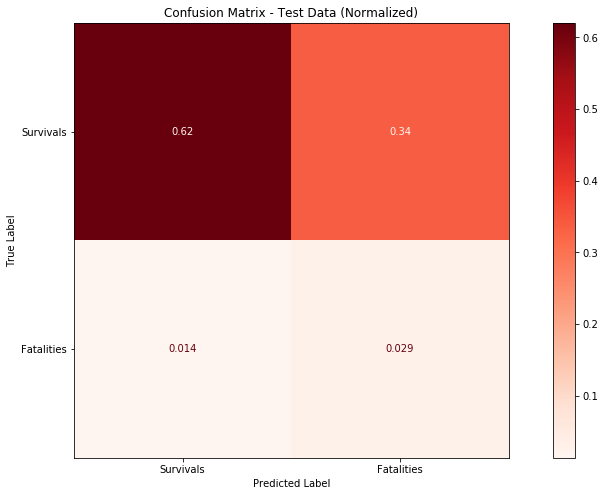

In [35]:
# Normalized confusion matrix plot for training and test data
y_class_names = ['Survivals','Fatalities']

fig2A, ax2A = plt.subplots(figsize=(16,8))
disp = plot_confusion_matrix(clf_ros,X_test,y_test,normalize='all',
                             ax=ax2A,display_labels=y_class_names,cmap='Reds')
ax2A.set_title('Confusion Matrix - Test Data: Random Over-Sampling (Normalized)')
ax2A.set_xlabel('Predicted Label')
ax2A.set_ylabel('True Label')

#plt.savefig('../graphics/CP1-04b_fig02A.png') # Export confusion matrix plot to PNG file
plt.show()

[TOC](#TOC)

<a id="Sec02B"></a>
#### 2B: Synthetic Minority Over-Sampling Technique (SMOTE)

In [30]:
from imblearn.over_sampling import SMOTE

In [31]:
# Make pipeline for sampling method and classifier
clf_smt = make_pipeline(SMOTE(random_state=RANDOM_STATE),
                        LogisticRegression(random_state=RANDOM_STATE,max_iter=10000,class_weight='balanced'))

/anaconda3/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


In [32]:
# Train the classifier with balancing
clf_smt.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Pipeline(memory=None,
         steps=[('smote',
                 SMOTE(k=None, k_neighbors=5, kind='regular', m=None,
                       m_neighbors=10, n_jobs=1, out_step=0.5, random_state=917,
                       ratio='auto', svm_estimator=None)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=10000,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=917,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))])

In [33]:
# Test the classifier and get the prediction
y_pred_test_smt = clf_smt.predict(X_test)

# Show the classification report
print(classification_report_imbalanced(y_test, y_pred_test_smt))

                   pre       rec       spe        f1       geo       iba       sup

      False       0.98      0.65      0.67      0.78      0.66      0.44   1912202
       True       0.08      0.67      0.65      0.14      0.66      0.44     84805

avg / total       0.94      0.65      0.67      0.76      0.66      0.44   1997007



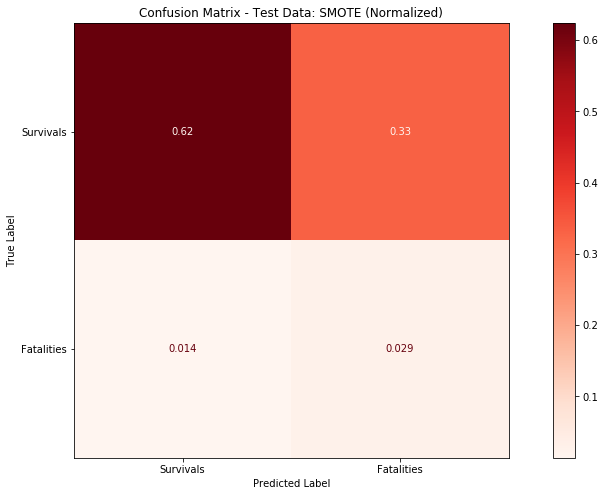

In [34]:
# Normalized confusion matrix plot for test data
y_class_names = ['Survivals','Fatalities']

fig2B, ax2B = plt.subplots(figsize=(16,8))
disp = plot_confusion_matrix(clf_smt,X_test,y_test,normalize='all',
                             ax=ax2B,display_labels=y_class_names,cmap='Reds')
ax2B.set_title('Confusion Matrix - Test Data: SMOTE (Normalized)')
ax2B.set_xlabel('Predicted Label')
ax2B.set_ylabel('True Label')

#plt.savefig('../graphics/CP1-04b_fig02B.png') # Export confusion matrix plot to PNG file
plt.show()

[TOC](#TOC)

<a id="Sec02C"></a>
#### 2C: Adapative Synthetic Sampling (ADASYN)

In [37]:
from imblearn.over_sampling import ADASYN

In [38]:
# Make pipeline for sampling method and classifier
clf_ads = make_pipeline(ADASYN(random_state=RANDOM_STATE),
                        LogisticRegression(random_state=RANDOM_STATE,max_iter=10000,class_weight='balanced'))

/anaconda3/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


In [39]:
# Train the classifier with balancing
clf_ads.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/imblearn/pipeline.py:190: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if memory.cachedir is None:
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Pipeline(memory=None,
         steps=[('adasyn',
                 ADASYN(k=None, n_jobs=1, n_neighbors=5, random_state=917,
                        ratio='auto')),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=10000,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=917,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))])

In [40]:
# Test the classifier and get the prediction
y_pred_test_ads = clf_ads.predict(X_test)

# Show the classification report
print(classification_report_imbalanced(y_test, y_pred_test_ads))

                   pre       rec       spe        f1       geo       iba       sup

      False       0.98      0.67      0.66      0.79      0.66      0.44   1912202
       True       0.08      0.66      0.67      0.14      0.66      0.44     84805

avg / total       0.94      0.67      0.66      0.77      0.66      0.44   1997007



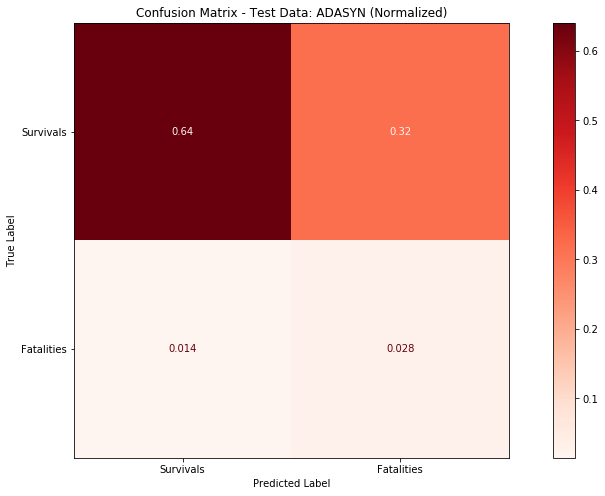

In [41]:
# Normalized confusion matrix plot for test data
y_class_names = ['Survivals','Fatalities']

fig2C, ax2C = plt.subplots(figsize=(16,8))
disp = plot_confusion_matrix(clf_ads,X_test,y_test,normalize='all',
                             ax=ax2C,display_labels=y_class_names,cmap='Reds')
ax2C.set_title('Confusion Matrix - Test Data: ADASYN (Normalized)')
ax2C.set_xlabel('Predicted Label')
ax2C.set_ylabel('True Label')

#plt.savefig('../graphics/CP1-04b_fig02C.png') # Export confusion matrix plot to PNG file
plt.show()

[TOC](#TOC)

***

## 3. UNDER-SAMPLING METHODS

<a id="Sec03A"></a>
#### 3A: Random Under-Sampling

In [42]:
from imblearn.under_sampling import RandomUnderSampler

In [43]:
# Make pipeline for sampling method and classifier
clf_rus = make_pipeline(RandomUnderSampler(random_state=RANDOM_STATE),
                        LogisticRegression(random_state=RANDOM_STATE,max_iter=10000,class_weight='balanced'))

/anaconda3/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


In [44]:
# Train the classifier with balancing
clf_rus.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/imblearn/pipeline.py:190: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if memory.cachedir is None:
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Pipeline(memory=None,
         steps=[('randomundersampler',
                 RandomUnderSampler(random_state=917, ratio='auto',
                                    replacement=False, return_indices=False)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=10000,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=917,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))])

In [45]:
# Test the classifier and get the prediction
y_pred_test_rus = clf_rus.predict(X_test)

# Show the classification report
print(classification_report_imbalanced(y_test, y_pred_test_rus))

                   pre       rec       spe        f1       geo       iba       sup

      False       0.98      0.65      0.68      0.78      0.66      0.44   1912202
       True       0.08      0.68      0.65      0.14      0.66      0.44     84805

avg / total       0.94      0.65      0.68      0.75      0.66      0.44   1997007



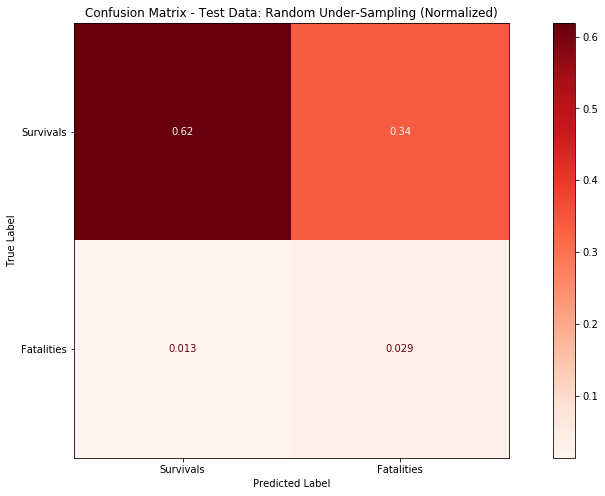

In [57]:
# Normalized confusion matrix plot for test data
y_class_names = ['Survivals','Fatalities']

fig3A, ax3A = plt.subplots(figsize=(16,8))
disp = plot_confusion_matrix(clf_rus,X_test,y_test,normalize='all',
                             ax=ax3A,display_labels=y_class_names,cmap='Reds')
ax3A.set_title('Confusion Matrix - Test Data: Random Under-Sampling (Normalized)')
ax3A.set_xlabel('Predicted Label')
ax3A.set_ylabel('True Label')

#plt.savefig('../graphics/CP1-04b_fig03A.png') # Export confusion matrix plot to PNG file
plt.show()

[TOC](#TOC)

<a id="Sec03B"></a>
#### 3B: Near Miss

In [48]:
from imblearn.under_sampling import NearMiss

In [49]:
# Make pipeline for sampling method and classifier
clf_nm = make_pipeline(NearMiss(random_state=RANDOM_STATE),
                       LogisticRegression(random_state=RANDOM_STATE,max_iter=10000,class_weight='balanced'))

/anaconda3/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


In [50]:
# Train the classifier with balancing
clf_nm.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/imblearn/pipeline.py:190: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if memory.cachedir is None:
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, c

Pipeline(memory=None,
         steps=[('nearmiss',
                 NearMiss(n_jobs=1, n_neighbors=3, n_neighbors_ver3=3,
                          random_state=917, ratio='auto', return_indices=False,
                          size_ngh=None, ver3_samp_ngh=None, version=1)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=10000,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=917,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))])

In [52]:
# Test the classifier and get the prediction
y_pred_test_nm = clf_nm.predict(X_test)

# Show the classification report
print(classification_report_imbalanced(y_test, y_pred_test_nm))

                   pre       rec       spe        f1       geo       iba       sup

      False       0.97      0.53      0.63      0.69      0.58      0.33   1912202
       True       0.06      0.63      0.53      0.10      0.58      0.34     84805

avg / total       0.93      0.54      0.63      0.66      0.58      0.34   1997007



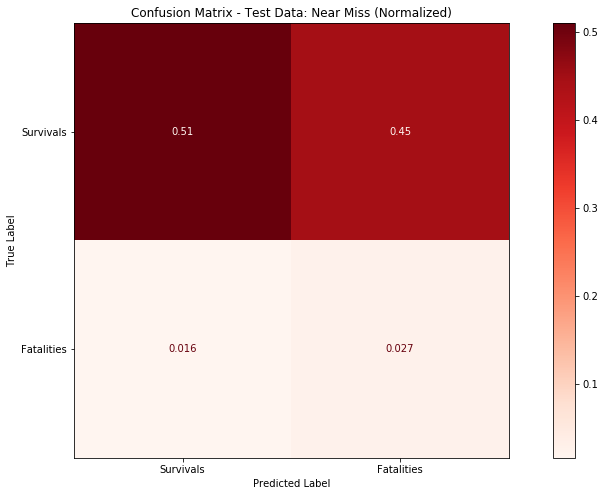

In [53]:
# Normalized confusion matrix plot for test data
y_class_names = ['Survivals','Fatalities']

fig3B, ax3B = plt.subplots(figsize=(16,8))
disp = plot_confusion_matrix(clf_nm,X_test,y_test,normalize='all',
                             ax=ax3B,display_labels=y_class_names,cmap='Reds')
ax3B.set_title('Confusion Matrix - Test Data: Near Miss (Normalized)')
ax3B.set_xlabel('Predicted Label')
ax3B.set_ylabel('True Label')

#plt.savefig('../graphics/CP1-04b_fig03B.png') # Export confusion matrix plot to PNG file
plt.show()

[TOC](#TOC)

<a id="Sec03C"></a>
#### 3C: Tomek's Links

In [54]:
from imblearn.under_sampling import TomekLinks

In [55]:
# Make pipeline for sampling method and classifier
clf_tl = make_pipeline(TomekLinks(random_state=RANDOM_STATE),
                       LogisticRegression(random_state=RANDOM_STATE,max_iter=10000,class_weight='balanced'))

/anaconda3/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


In [56]:
# Train the classifier with balancing
clf_tl.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/imblearn/pipeline.py:190: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if memory.cachedir is None:
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Pipeline(memory=None,
         steps=[('tomeklinks',
                 TomekLinks(n_jobs=1, random_state=917, ratio='auto',
                            return_indices=False)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=10000,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=917,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))])

In [58]:
# Test the classifier and get the prediction
y_pred_test_tl = clf_tl.predict(X_test)

# Show the classification report
print(classification_report_imbalanced(y_test, y_pred_test_tl))

                   pre       rec       spe        f1       geo       iba       sup

      False       0.98      0.66      0.67      0.79      0.67      0.44   1912202
       True       0.08      0.67      0.66      0.14      0.67      0.44     84805

avg / total       0.94      0.66      0.67      0.76      0.67      0.44   1997007



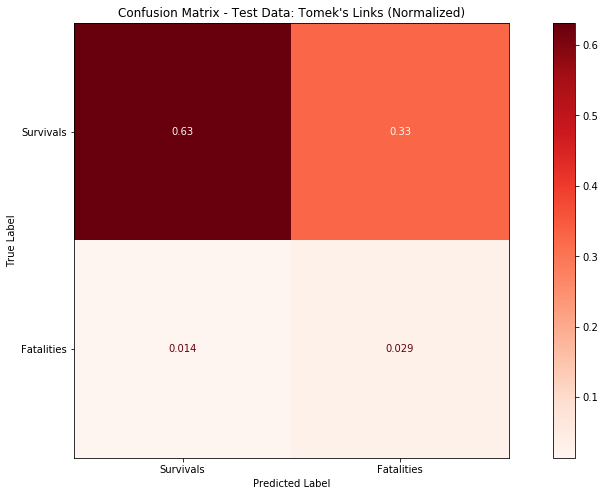

In [59]:
# Normalized confusion matrix plot for test data
y_class_names = ['Survivals','Fatalities']

fig3C, ax3C = plt.subplots(figsize=(16,8))
disp = plot_confusion_matrix(clf_tl,X_test,y_test,normalize='all',
                             ax=ax3C,display_labels=y_class_names,cmap='Reds')
ax3C.set_title('Confusion Matrix - Test Data: Tomek\'s Links (Normalized)')
ax3C.set_xlabel('Predicted Label')
ax3C.set_ylabel('True Label')

#plt.savefig('../graphics/CP1-04b_fig03C.png') # Export confusion matrix plot to PNG file
plt.show()

[TOC](#TOC)

***

## 4. COMBINATION METHOD

<a id="Sec04A"></a>
#### 4A: Balanced Random Forest

In [69]:
from imblearn.ensemble import BalancedRandomForestClassifier
#from sklearn.ensemble import RandomForestClassifier

ImportError: cannot import name 'BalancedRandomForestClassifier'

In [64]:
# Make pipeline for sampling method and classifier
clf_rf = RandomForestClassifier(random_state=RANDOM_STATE)

/anaconda3/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


NO hyper 

1) Resource is not recoginzed

2) 

In [68]:
import matplotlib.pyplot as plt

from collections import OrderedDict
from sklearn.ensemble import RandomForestClassifier


# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for parallelized ensembles but is necessary for tracking the OOB
# error trajectory during training.
ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(warm_start=True, oob_score=True,
                               max_features="sqrt",
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(warm_start=True, max_features='log2',
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(warm_start=True, max_features=None,
                               oob_score=True,
                               random_state=RANDOM_STATE))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 15
max_estimators = 20

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X_bin, y_bin)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few tre

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(ax

KeyboardInterrupt: 

In [ ]:
# Train the classifier with balancing
clf_rf.fit(X_train, y_train)

In [ ]:
# Test the classifier and get the prediction
y_pred_test_rf = clf_rf.predict(X_test)

# Show the classification report
print(classification_report_imbalanced(y_test, y_pred_test_rf))

In [ ]:
# Normalized confusion matrix plot for test data
y_class_names = ['Survivals','Fatalities']

fig4A, ax4A = plt.subplots(figsize=(16,8))
disp = plot_confusion_matrix(clf_rf,X_test,y_test,normalize='all',
                             ax=ax4A,display_labels=y_class_names,cmap='Reds')
ax4A.set_title('Confusion Matrix - Test Data: Random Forest (Normalized)')
ax4A.set_xlabel('Predicted Label')
ax4A.set_ylabel('True Label')

#plt.savefig('../graphics/CP1-04b_fig04A.png') # Export confusion matrix plot to PNG file
plt.show()

[TOC](#TOC)

***

## 4. EVALUATION OF CLASSIFIERS

__Determine which metric I want to optimize for within the context of this problem--precision, recall, F1--and proivde a justification for my choice.__

ANSWER: Optimize for __recall/sensitivity__ (Fraction of positives that were correctly identified)

__Use LogisticRegression (parametric) and RandomForest (non-parametric) classifiers__

BDE --->> Deep Neural Networks

Consider additional algorithms (SVM, neural networks)

XGBoost???

Do not compare results from training and test sets for RandomForest

Only compare performance between classifiers on test sets only.